In [ ]:
!git clone https://github.com/Francis-Komizu/data-science-experiment

Cloning into 'data-science-experiment'...
remote: Enumerating objects: 227, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 227 (delta 40), reused 187 (delta 19), pack-reused 0
Receiving objects: 100% (227/227), 6.08 MiB | 22.80 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [ ]:
from hubert.model import *
from acoustic.model import *
from hifigan.generator import *

URLS = {
    "hubert-discrete": "https://github.com/bshall/hubert/releases/download/v0.1/hubert-discrete-e9416457.pt",
    "hubert-soft": "https://github.com/bshall/hubert/releases/download/v0.1/hubert-soft-0d54a1f4.pt",
    "kmeans100": "https://github.com/bshall/hubert/releases/download/v0.1/kmeans100-50f36a95.pt",
    "hifigan": "https://github.com/bshall/hifigan/releases/download/v0.1/hifigan-67926ec6.pt",
    "hifigan-hubert-soft": "https://github.com/bshall/hifigan/releases/download/v0.1/hifigan-hubert-discrete-bbad3043.pt",
    "hifigan-hubert-discrete": "https://github.com/bshall/hifigan/releases/download/v0.1/hifigan-hubert-soft-65f03469.pt",
    
}
URLS_2 = {
    "hubert-discrete": "https://github.com/bshall/acoustic-model/releases/download/v0.1/hubert-discrete-d49e1c77.pt",
    "hubert-soft": "https://github.com/bshall/acoustic-model/releases/download/v0.1/hubert-soft-0321fd7e.pt",
}


def hubert_soft_2(
    pretrained: bool = True,
    progress: bool = True,
) -> HubertSoft:
    r"""HuBERT-Soft from `"A Comparison of Discrete and Soft Speech Units for Improved Voice Conversion"`.
    Args:
        pretrained (bool): load pretrained weights into the model
        progress (bool): show progress bar when downloading model
    """
    hubert = HubertSoft()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            URLS["hubert-soft"], progress=progress
        )
        consume_prefix_in_state_dict_if_present(checkpoint, "module.")
        hubert.load_state_dict(checkpoint)
        hubert.eval()
    return hubert

def _hifigan(
    name: str,
    pretrained: bool = True,
    progress: bool = True,
    map_location=None,
) -> HifiganGenerator:
    hifigan = HifiganGenerator()
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(
            URLS[name], map_location=map_location, progress=progress
        )
        consume_prefix_in_state_dict_if_present(checkpoint, "module.")
        hifigan.load_state_dict(checkpoint)
        hifigan.eval()
        hifigan.remove_weight_norm()
    return hifigan


def acoustic_2(
    pretrained: bool = True,
    progress: bool = True,
) -> AcousticModel:
    r"""HuBERT-Soft acoustic model from `"A Comparison of Discrete and Soft Speech Units for Improved Voice Conversion"`.
    Args:
        pretrained (bool): load pretrained weights into the model
        progress (bool): show progress bar when downloading model
    """
    return _acoustic(
        "hubert-soft",
        discrete=False,
        upsample=True,
        pretrained=pretrained,
        progress=progress,
    )

def _acoustic(
    name: str,
    discrete: bool,
    upsample: bool,
    pretrained: bool = True,
    progress: bool = True,
) -> AcousticModel:
    acoustic = AcousticModel(discrete, upsample)
    if pretrained:
        checkpoint = torch.hub.load_state_dict_from_url(URLS_2[name], progress=progress)
        consume_prefix_in_state_dict_if_present(checkpoint["acoustic-model"], "module.")
        acoustic.load_state_dict(checkpoint["acoustic-model"])
        acoustic.eval()
    return acoustic


def hifigan_hubert_soft(
    pretrained: bool = True, progress: bool = True, map_location=None
) -> HifiganGenerator:
    return _hifigan("hifigan-hubert-soft", pretrained, progress, map_location=None)



In [ ]:
hubert_model = hubert_soft_2(pretrained=True, progress=True).cuda()
acoustic = acoustic_2(pretrained=True, progress=True).cuda()
hifigan = hifigan_hubert_soft(pretrained=True, progress=True).cuda()

Removing weight norm...


In [ ]:
# Load the source audio
source, sr = torchaudio.load("/content/data-science-experiment/autovc/wavs/p225xp225.wav")
assert sr == 16000
source = source.unsqueeze(0).cuda()

# Convert to the target speaker
with torch.inference_mode():
    # Extract speech units
    units = hubert.units(source)
    # Generate target spectrogram
    mel = acoustic.generate(units).transpose(1, 2)
    # Generate audio waveform
    target = hifigan(mel)

In [ ]:
units

tensor([[[ 0.1021, -0.3389, -0.5846,  ...,  0.4140, -0.6219,  0.3407],
         [ 0.0766, -0.4676, -0.4984,  ...,  0.5634, -0.4943,  0.2667],
         [ 0.1320, -0.1712, -0.4509,  ...,  0.1705, -0.3894,  0.2729],
         ...,
         [-0.2021, -0.4033, -0.1691,  ..., -0.1984,  0.0123, -0.5324],
         [-0.1188, -0.3483, -0.0338,  ...,  0.0299, -0.0179, -0.3806],
         [-0.0467, -0.3019, -0.3541,  ...,  0.1299, -0.2854,  0.0375]]],
       device='cuda:0')

In [ ]:
mel

tensor([[[-7.2114, -8.0591, -8.6419,  ..., -9.2870, -9.2361, -8.8057],
         [-6.4433, -7.0641, -7.3784,  ..., -8.0547, -8.3092, -7.9549],
         [-6.4388, -6.9213, -7.1267,  ..., -7.6817, -7.7525, -7.4554],
         ...,
         [-8.0963, -9.1324, -9.5056,  ..., -9.4091, -9.3520, -9.3710],
         [-8.1613, -9.1619, -9.5527,  ..., -9.5491, -9.4031, -9.3549],
         [-8.3354, -9.2128, -9.6006,  ..., -9.7045, -9.4562, -9.3312]]],
       device='cuda:0')

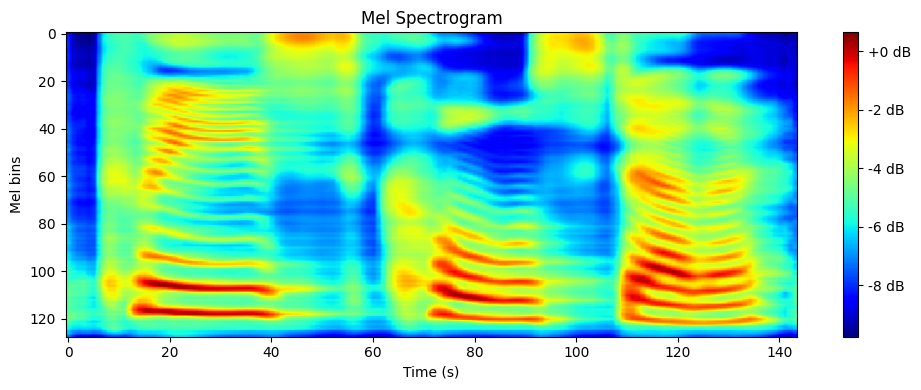

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(10, 4))
plt.imshow(np.flipud(mel.squeeze().cpu()), aspect='auto', cmap='jet')
plt.title('Mel Spectrogram')
plt.ylabel('Mel bins')
plt.xlabel('Time (s)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


In [ ]:
target

tensor([[[0.0008, 0.0012, 0.0015,  ..., 0.0003, 0.0009, 0.0011]]],
       device='cuda:0')

In [ ]:
import IPython.display as display
display.Audio(target.squeeze().cpu(), rate=16000)